<a href="https://colab.research.google.com/github/wayrayfr/2025-2-URP3/blob/main/URP3_model_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import io

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class FTIRDataProcessor:
    def __init__(self, csv_path):
        """FTIR CSV 데이터 로드"""
        self.df = pd.read_csv(csv_path, index_col=0)
        self.labels = self.df.index.tolist()
        self.wavenumbers = self.df.columns.astype(float).tolist()
        self.spectra = self.df.values

        # NaN 처리
        self.spectra = np.nan_to_num(self.spectra, nan=0.0)

        # 레이블 인코딩
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(self.labels)

    def get_raw_features(self):
        """Raw FTIR 스펙트럼 반환"""
        return self.spectra

    def generate_spectrum_image(self, spectrum, save_path=None, dpi=100):
        """스펙트럼을 이미지로 변환"""
        fig, ax = plt.subplots(figsize=(2.24, 2.24), dpi=dpi)
        ax.plot(self.wavenumbers, spectrum, linewidth=1.5, color='blue')
        ax.set_xlim(max(self.wavenumbers), min(self.wavenumbers))
        ax.axis('off')
        plt.tight_layout(pad=0)

        # 이미지로 변환
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        img = Image.open(buf).convert('RGB')
        plt.close()

        if save_path:
            img.save(save_path)

        return img

    def prepare_dual_modality_data(self):
        """Dual-modality 데이터 준비"""
        images = []
        for spectrum in self.spectra:
            img = self.generate_spectrum_image(spectrum)
            images.append(img)

        return self.spectra, images, self.encoded_labels

# 데이터 로드
processor = FTIRDataProcessor('/content/drive/MyDrive/2025/URP/merged_filtered.csv')
raw_spectra, spectrum_images, labels = processor.prepare_dual_modality_data()

print(f"Raw spectra shape: {raw_spectra.shape}")
print(f"Number of images: {len(spectrum_images)}")
print(f"Labels shape: {labels.shape}")
print(f"Classes: {processor.label_encoder.classes_}")

Raw spectra shape: (1709, 3551)
Number of images: 1709
Labels shape: (1709,)
Classes: ['Cellulose acetate' 'EPR' 'Morphotype 1' 'PA' 'PE' 'PEVA' 'PP' 'PS']


In [ ]:
class DualModalityDataset(Dataset):
    def __init__(self, raw_spectra, images, labels, transform=None):
        self.raw_spectra = raw_spectra
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        raw = torch.FloatTensor(self.raw_spectra[idx])
        img = self.images[idx]

        if self.transform:
            img = self.transform(img)

        label = torch.LongTensor([self.labels[idx]])

        return raw, img, label

# 이미지 전처리 (ResNet18용)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

In [ ]:
class ResNet18FeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet18FeatureExtractor, self).__init__()
        resnet = models.resnet18(pretrained=pretrained)
        # 마지막 FC layer 제거
        self.features = nn.Sequential(*list(resnet.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # (batch, 512)
        return x

# 모델 초기화
feature_extractor = ResNet18FeatureExtractor(pretrained=True).to(device)
feature_extractor.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 34.6MB/s]


ResNet18FeatureExtractor(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
def extract_cnn_features(images, model, transform, batch_size=32):
    """CNN으로 이미지 feature 추출"""
    model.eval()
    features_list = []

    # Dataset 생성
    temp_dataset = []
    for img in images:
        temp_dataset.append(transform(img))

    # DataLoader 생성
    temp_loader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for batch in temp_loader:
            batch = batch.to(device)
            features = model(batch)
            features_list.append(features.cpu().numpy())

    return np.vstack(features_list)

# CNN features 추출
print("Extracting CNN features from spectrum images...")
cnn_features = extract_cnn_features(spectrum_images, feature_extractor, transform)
print(f"CNN features shape: {cnn_features.shape}")  # (N, 512)

# Raw spectra 정규화
scaler_raw = StandardScaler()
raw_features_scaled = scaler_raw.fit_transform(raw_spectra)

# CNN features 정규화
scaler_cnn = StandardScaler()
cnn_features_scaled = scaler_cnn.fit_transform(cnn_features)

# Dual-modality: Raw + CNN features 결합
dual_features = np.concatenate([raw_features_scaled, cnn_features_scaled], axis=1)
print(f"Dual-modality features shape: {dual_features.shape}")

Extracting CNN features from spectrum images...
CNN features shape: (1709, 512)
Dual-modality features shape: (1709, 4063)


In [ ]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    dual_features, labels, test_size=0.2, random_state=42, stratify=labels
)

# ML 모델 정의
models_dict = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVC': SVC(kernel='rbf', random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# 모델 학습 및 평가
results = {}

for name, model in models_dict.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    print(f"{'='*50}")

    # 학습
    model.fit(X_train, y_train)

    # 예측
    y_pred = model.predict(X_test)

    # 평가
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"\nAccuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred,
                                target_names=processor.label_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"\nCross-validation scores: {cv_scores}")
    print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# 결과 요약
print(f"\n{'='*50}")
print("FINAL RESULTS SUMMARY")
print(f"{'='*50}")
for name, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name:25s}: {acc:.4f}")


Training Logistic Regression...

Accuracy: 0.9942

Classification Report:
                   precision    recall  f1-score   support

Cellulose acetate       1.00      1.00      1.00        11
              EPR       1.00      1.00      1.00        10
     Morphotype 1       1.00      1.00      1.00        11
               PA       1.00      1.00      1.00         4
               PE       1.00      0.99      0.99       177
             PEVA       0.82      1.00      0.90         9
               PP       1.00      1.00      1.00       104
               PS       1.00      1.00      1.00        16

         accuracy                           0.99       342
        macro avg       0.98      1.00      0.99       342
     weighted avg       1.00      0.99      0.99       342


Confusion Matrix:
[[ 11   0   0   0   0   0   0   0]
 [  0  10   0   0   0   0   0   0]
 [  0   0  11   0   0   0   0   0]
 [  0   0   0   4   0   0   0   0]
 [  0   0   0   0 175   2   0   0]
 [  0   0   0   0   

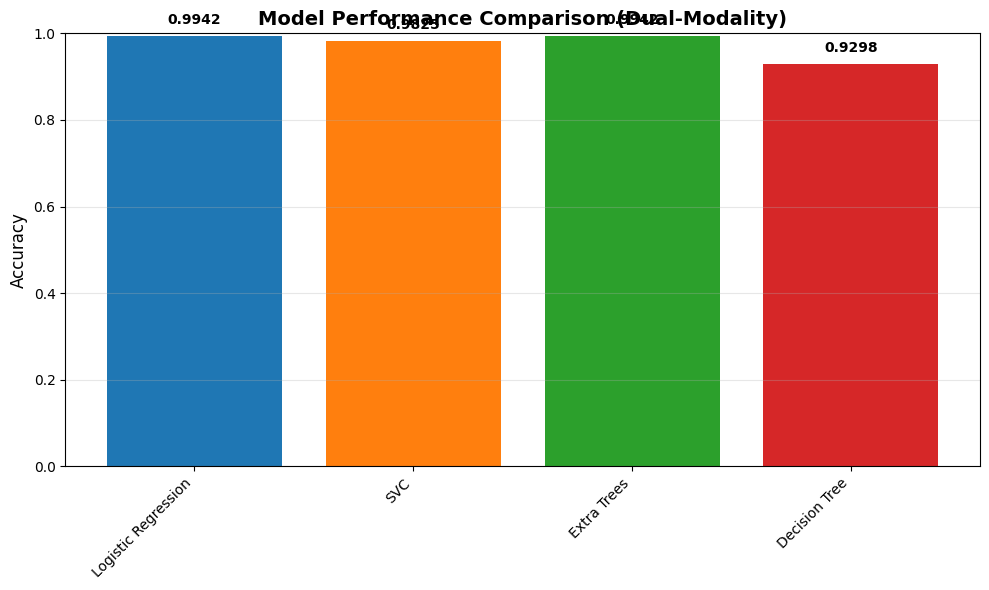

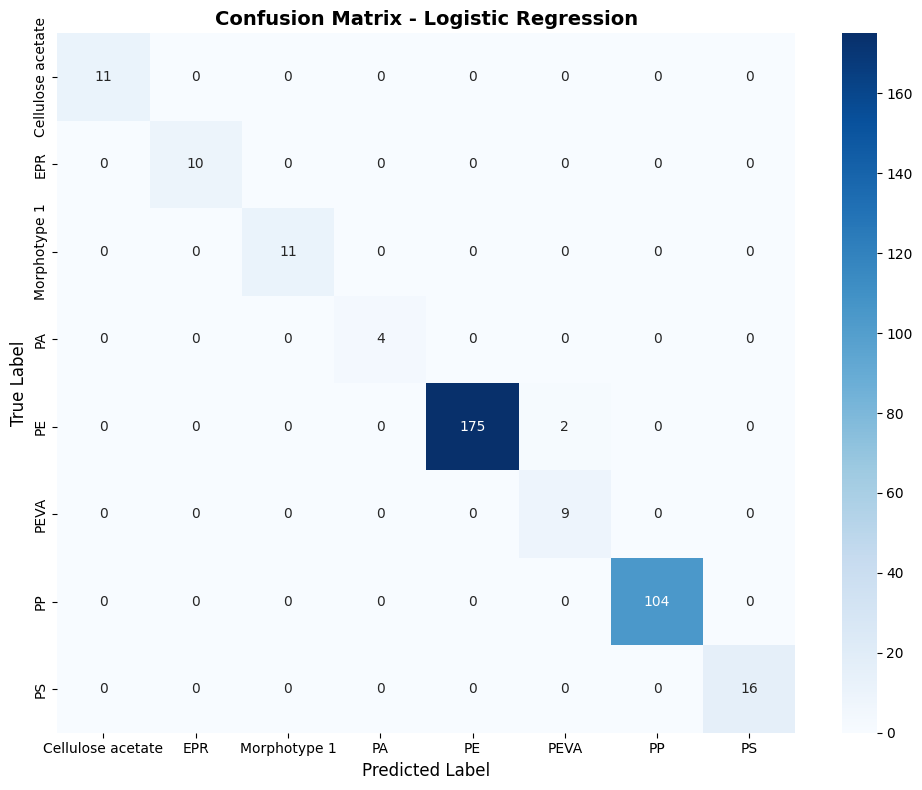

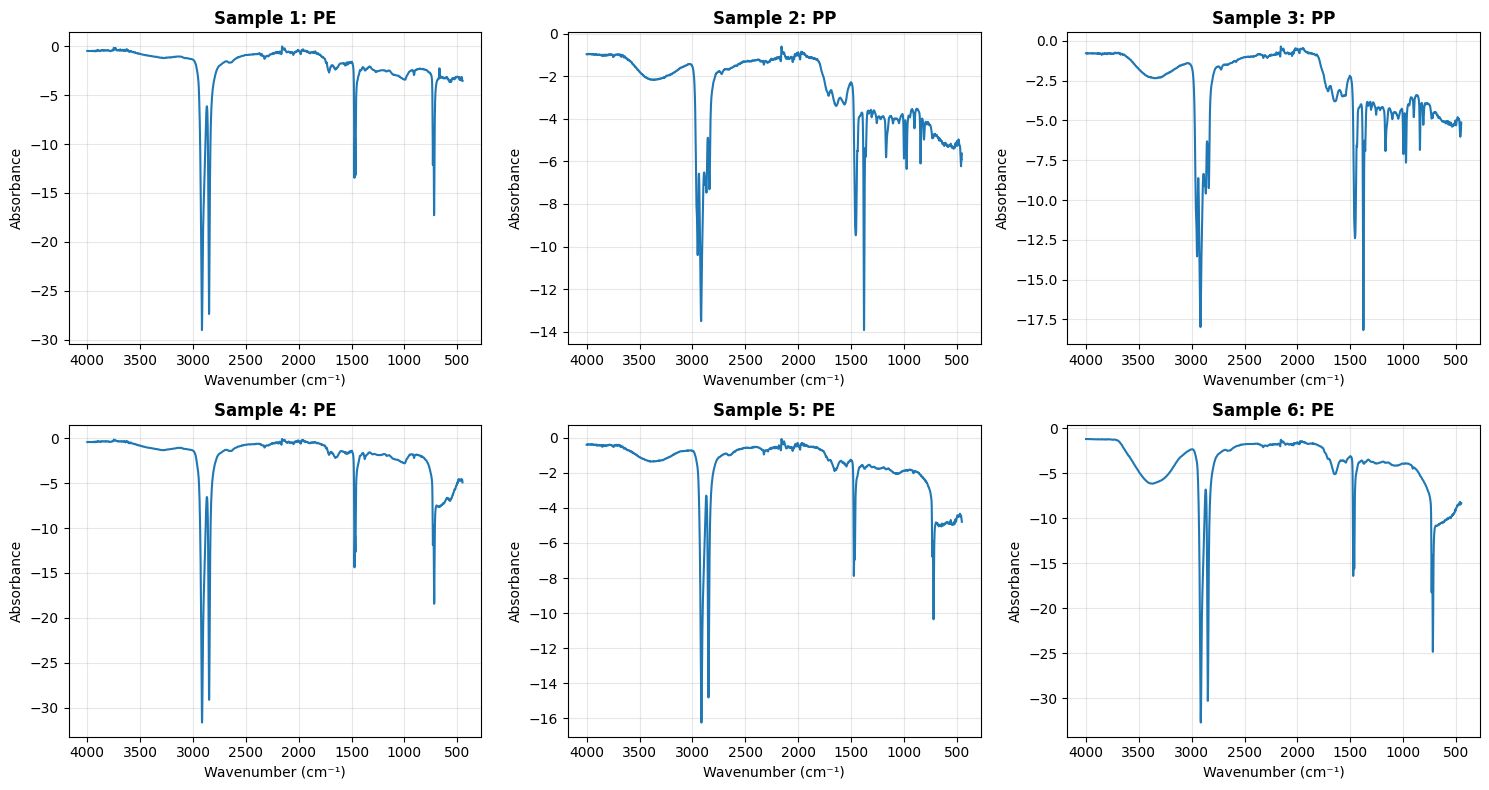

In [ ]:
import seaborn as sns

# 1. 모델 성능 비교
plt.figure(figsize=(10, 6))
models_names = list(results.keys())
accuracies = list(results.values())

plt.bar(models_names, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Performance Comparison (Dual-Modality)', fontsize=14, fontweight='bold')
plt.ylim([0, 1])
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300)
plt.show()

# 2. Confusion Matrix (최고 성능 모델)
best_model_name = max(results, key=results.get)
best_model = models_dict[best_model_name]
y_pred_best = best_model.predict(X_test)
cm_best = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=processor.label_encoder.classes_,
            yticklabels=processor.label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_best.png', dpi=300)
plt.show()

# 3. 샘플 스펙트럼 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx in range(6):
    if idx < len(raw_spectra):
        axes[idx].plot(processor.wavenumbers, raw_spectra[idx], linewidth=1.5)
        axes[idx].set_title(f'Sample {idx+1}: {processor.labels[idx]}', fontweight='bold')
        axes[idx].set_xlabel('Wavenumber (cm⁻¹)')
        axes[idx].set_ylabel('Absorbance')
        axes[idx].invert_xaxis()
        axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('sample_spectra.png', dpi=300)
plt.show()

In [ ]:
import joblib

# 최고 성능 모델 저장
joblib.dump(best_model, f'best_model_{best_model_name.replace(" ", "_")}.pkl')
joblib.dump(scaler_raw, 'scaler_raw.pkl')
joblib.dump(scaler_cnn, 'scaler_cnn.pkl')
joblib.dump(processor.label_encoder, 'label_encoder.pkl')
torch.save(feature_extractor.state_dict(), 'resnet18_feature_extractor.pth')

print(f"\n✅ Models saved successfully!")
print(f"Best model: {best_model_name} (Accuracy: {results[best_model_name]:.4f})")


✅ Models saved successfully!
Best model: Logistic Regression (Accuracy: 0.9942)
